In [1]:
import pandas as pd
from darts import TimeSeries
from darts.models import TransformerModel
from darts.metrics import mse, rmse, r2_score, mae, smape
from darts.dataprocessing.transformers import Scaler
import torch
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from plotnine import (
    ggplot, aes, geom_line, facet_wrap, labs, theme_bw, theme,
    element_text, element_blank, geom_col, coord_flip
)
import json


torch.set_float32_matmul_precision('medium')


In [2]:
target_columns = [
    'Temperature','Precipitation_accumulated','Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]

DATA_FILE_PATH = "data/ground_station_clean.csv"
df = pd.read_csv(DATA_FILE_PATH)

In [3]:
encoders = {
    "cyclic": {
        "past": ["month", "dayofyear", "day", "hour", "minute"],
        "future": ["month", "dayofyear", "day", "hour", "minute"]
    },
    "transformer": Scaler(),
    "datetime_attribute": {
        "past": ["year"],
        "future": ["year"]
    }
}

In [4]:
best_r2 = float('-inf')
best_fold = -1
best_train_scaled = None
best_val_scaled = None
best_scaler = None
best_metrics = None
best_forecasts = None
# Definir parâmetros do modelo

tscv = TimeSeriesSplit(n_splits=7)
fold_metrics = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(df)):

    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=10, verbose=True)
    pl_trainer_kwargs = {
        "accelerator": "auto",
        "callbacks": [early_stopper],
    }
    train_df_fold, val_df_fold = df.iloc[train_idx], df.iloc[val_idx]
    train_fold = TimeSeries.from_dataframe(train_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')
    val_fold = TimeSeries.from_dataframe(val_df_fold, time_col="Timestamp", value_cols=target_columns, freq='1h')

    print(f"\n{'='*50}\nFold {fold+1}\n{'='*50}")
    print("\nTreinando o modelo...")
    print(f"Train set: {train_fold.shape[0]} samples")
    print(f"Validation set: {val_fold.shape[0]} samples")
    
    scaler = Scaler()
    # Ajustar o scaler apenas nos dados de treino para evitar data leakage
    scaler = scaler.fit(train_fold)
    # Transformar todas as séries
    train_scaled = scaler.transform(train_fold)
    val_scaled = scaler.transform(val_fold)
    

    model = TransformerModel(
        model_name=f"model_{fold+1}",
        input_chunk_length=28,
        output_chunk_length=2,
        d_model=128,
        nhead=4,
        num_encoder_layers=1,
        num_decoder_layers=1,
        activation="Bilinear",
        n_epochs=100,
        batch_size=153,
        dropout=0.11806248396557542,
        add_encoders=encoders,
        pl_trainer_kwargs=pl_trainer_kwargs,
        loss_fn=torch.nn.HuberLoss(),
        optimizer_cls=torch.optim.Adam,
        lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
        lr_scheduler_kwargs={"mode": "min", "factor": 0.3, "patience": 5, "min_lr": 1e-7},
        save_checkpoints=True,
        show_warnings=True,
        force_reset=True,
        random_state=42,
        optimizer_kwargs={"lr": 0.0007930360578326748, "weight_decay": 0.00013997625135104947}
    )
    model.fit(
        series=train_scaled,
        val_series=val_scaled,
        dataloader_kwargs={"num_workers": 11},
        verbose=False,
    )
    
    model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{fold+1}/", best=True)

    forecasts = model.historical_forecasts(
        val_scaled,
        forecast_horizon=2,
        stride=1,
        retrain=False,
        verbose=False,
        last_points_only=True,
    ) 

    forecasts_t = scaler.inverse_transform(forecasts)
    s = scaler.inverse_transform(val_scaled)
    metrics = {}
    print("Iniciando a verificação das séries temporais para constância...")
    try:
        for target in target_columns:
            metrics[target] = {
                'MSE': mse(s[target], forecasts_t[target]),
                'RMSE': rmse(s[target], forecasts_t[target]),
                'MAE': mae(s[target], forecasts_t[target]),
                'R2': r2_score(s[target], forecasts_t[target]),
                'SMAPE': smape(s[target], forecasts_t[target]),
            }
        metrics_df = pd.DataFrame(metrics).T
        print("\nMétricas de performance:")
        print(metrics_df)
    except Exception as e:
        print(e)

    r2_geral = r2_score(s, forecasts_t)
    print(f"O R2 desse fold foi {r2_geral}")
    if best_r2 < r2_geral:
        best_r2 = r2_geral
        best_fold = fold + 1
        best_train_scaled = train_scaled
        best_scaler = scaler
        best_metrics = metrics_df
        best_forecasts = forecasts
        best_val_scaled = val_scaled

print(f"O melhor fold foi {best_fold}")



Fold 1

Treinando o modelo...
Train set: 1043 samples
Validation set: 1038 samples


Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Metric val_loss improved. New best score: 0.044
Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.031
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.029
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.027
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.024
Metric val_loss improved by 0.001

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                     MSE        RMSE         MAE        R2  \
Temperature                     9.595321    3.097632    2.478119  0.808358   
Precipitation_accumulated       0.385065    0.620536    0.441287  0.389119   
Humidity                       76.276939    8.733667    6.815519  0.757101   
Wind_Speed_kmh                  0.437774    0.661645    0.526689 -0.035779   
Soil_Moisture              112800.025000  335.857150  255.848822  0.818213   
Soil_Temperature               14.856353    3.854394    2.864909  0.795832   
Wind_Dir_Sin                    0.322290    0.567706    0.454203 -0.008488   
Wind_Dir_Cos                    0.457347    0.676274    0.516285 -0.182303   

                                SMAPE  
Temperature                 15.350529  
Precipitation_accumulated   13.485551  
Humidity                    11.120664  
Wind_Speed_kmh              51.997036  
Soil_Mo

Metric val_loss improved. New best score: 6.233
Metric val_loss improved by 0.041 >= min_delta = 0.001. New best score: 6.192
Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 6.184
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 6.178
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 6.173
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 6.172
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 6.166
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 6.161
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 6.157
Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 6.152
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 6.150
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 6.147
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 6.145
Metric val_loss 

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE         MAE         R2  \
Temperature                3.296102e+02    18.155169   15.548011  -8.501615   
Precipitation_accumulated  1.435782e+05   378.917186  323.799514  -2.625428   
Humidity                   3.236922e+03    56.893951   49.325339 -24.801789   
Wind_Speed_kmh             9.913970e-01     0.995689    0.880144  -2.025557   
Soil_Moisture              1.429300e+06  1195.533321  999.401207   0.044142   
Soil_Temperature           2.780558e+02    16.675007   14.162342  -6.761096   
Wind_Dir_Sin               1.786153e-01     0.422629    0.311681   0.245306   
Wind_Dir_Cos               1.324936e+00     1.151059    0.986088  -1.030608   

                                SMAPE  
Temperature                149.576356  
Precipitation_accumulated  143.799031  
Humidity                    96.186318  
Wind_Speed_kmh             130.251294 

Metric val_loss improved. New best score: 0.022
Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.016
Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.012
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.010
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.008
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.006
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.004
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.003. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inferenc

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE            R2  \
Temperature                    6.192642    2.488502    1.982614 -1.132987e-01   
Precipitation_accumulated   4609.259801   67.891530   65.559551 -3.915378e+07   
Humidity                      26.551264    5.152792    4.328366 -5.417152e-01   
Wind_Speed_kmh                 0.023620    0.153690    0.118966          -inf   
Soil_Moisture              39272.060355  198.171795  159.004377 -2.834802e+01   
Soil_Temperature               6.056422    2.460980    1.993022  4.077371e-02   
Wind_Dir_Sin                   0.007057    0.084009    0.063790          -inf   
Wind_Dir_Cos                   0.043496    0.208556    0.179831          -inf   

                                SMAPE  
Temperature                 13.082676  
Precipitation_accumulated   13.294334  
Humidity                     4.859490  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.008
Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.005
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.004
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE           R2  \
Temperature                    4.422714    2.103025    1.842925    -6.845020   
Precipitation_accumulated     64.060370    8.003772    6.356461 -1937.653366   
Humidity                      22.294248    4.721679    3.904798    -1.284808   
Wind_Speed_kmh                 0.049283    0.221998    0.181949         -inf   
Soil_Moisture              40189.329843  200.472766  152.473213    -0.163548   
Soil_Temperature               3.310908    1.819590    1.554067   -13.635516   
Wind_Dir_Sin                   0.001691    0.041125    0.034618         -inf   
Wind_Dir_Cos                   0.021287    0.145900    0.139537         -inf   

                                SMAPE  
Temperature                 17.456889  
Precipitation_accumulated    1.375305  
Humidity                     4.272644  
Wind_Speed_kmh             20

Metric val_loss improved. New best score: 0.007
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.005
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.002. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.p

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                   MSE       RMSE        MAE          R2  \
Temperature                   2.337446   1.528871   1.247798    0.015806   
Precipitation_accumulated    56.240694   7.499380   6.054957 -196.768912   
Humidity                     98.925510   9.946130   8.097246   -1.121358   
Wind_Speed_kmh                0.091321   0.302194   0.243419  -42.914115   
Soil_Moisture              8459.497517  91.975527  68.068882   -0.051372   
Soil_Temperature              2.056484   1.434045   1.138973   -0.269051   
Wind_Dir_Sin                  0.027064   0.164510   0.079037    0.532101   
Wind_Dir_Cos                  0.052298   0.228687   0.114932    0.408469   

                                SMAPE  
Temperature                 17.391980  
Precipitation_accumulated    1.306240  
Humidity                     9.431367  
Wind_Speed_kmh             192.985178  
Soil_Moisture            

Metric val_loss improved. New best score: 0.030
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.028
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.025
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.023
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.022
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.020
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.019
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.019. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, us

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE         RMSE          MAE          R2  \
Temperature                1.059009e+01     3.254241     2.590048   -0.128088   
Precipitation_accumulated  2.122208e+02    14.567801    12.165815 -182.311050   
Humidity                   5.881453e+01     7.669063     6.862851    0.490022   
Wind_Speed_kmh             1.221036e+00     1.105005     0.753414    0.215156   
Soil_Moisture              1.423510e+06  1193.109220  1059.054313   -0.113787   
Soil_Temperature           2.878570e+00     1.696635     1.382524    0.428106   
Wind_Dir_Sin               4.757659e-01     0.689758     0.541559    0.004058   
Wind_Dir_Cos               3.926583e-01     0.626625     0.485993    0.195339   

                                SMAPE  
Temperature                 79.053699  
Precipitation_accumulated    2.614363  
Humidity                     7.768948  
Wind_Speed_kmh      

Metric val_loss improved. New best score: 0.019
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.017
Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.015
Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.014
Monitored metric val_loss did not improve in the last 10 records. Best score: 0.014. Signaling Trainer to stop.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.p

Iniciando a verificação das séries temporais para constância...

Métricas de performance:
                                    MSE        RMSE         MAE          R2  \
Temperature                    5.077899    2.253419    1.820435    0.812327   
Precipitation_accumulated    164.677401   12.832669   10.379107 -562.471058   
Humidity                      52.124363    7.219720    5.844705    0.654990   
Wind_Speed_kmh                 1.095782    1.046796    0.868518    0.088136   
Soil_Moisture              21677.073516  147.231361  121.233643   -2.665357   
Soil_Temperature               2.113257    1.453705    1.204717    0.810476   
Wind_Dir_Sin                   0.486971    0.697833    0.572662    0.091697   
Wind_Dir_Cos                   0.331473    0.575737    0.482370    0.024751   

                                SMAPE  
Temperature                 19.286697  
Precipitation_accumulated    2.230565  
Humidity                     7.217824  
Wind_Speed_kmh              66.928287 

In [5]:
model.load_from_checkpoint(f"/home/eduardo/Documentos/Water-Cycle-Neural-Network/darts_logs/model_{best_fold}/", best=True)

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)


TransformerModel(output_chunk_shift=0, d_model=128, nhead=4, num_encoder_layers=1, num_decoder_layers=1, dim_feedforward=512, dropout=0.11806248396557542, activation=Bilinear, norm_type=None, custom_encoder=None, custom_decoder=None, model_name=model_1, input_chunk_length=28, output_chunk_length=2, n_epochs=100, batch_size=153, add_encoders={'cyclic': {'past': ['month', 'dayofyear', 'day', 'hour', 'minute'], 'future': ['month', 'dayofyear', 'day', 'hour', 'minute']}, 'transformer': Scaler, 'datetime_attribute': {'past': ['year'], 'future': ['year']}}, pl_trainer_kwargs={'accelerator': 'auto', 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7f1795d3a720>]}, loss_fn=HuberLoss(), optimizer_cls=<class 'torch.optim.adam.Adam'>, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, lr_scheduler_kwargs={'mode': 'min', 'factor': 0.3, 'patience': 5, 'min_lr': 1e-07}, save_checkpoints=True, show_warnings=True, force_reset=True, random_state=42

In [6]:
s = best_scaler.inverse_transform(best_val_scaled)
forecasts_t = best_scaler.inverse_transform(best_forecasts)
s_df = s.to_dataframe()
s_df = s_df.reset_index()
forecasts_t_df = forecasts_t.to_dataframe()
forecasts_t_df = forecasts_t_df.reset_index()
forecasts_t_df = forecasts_t_df.rename(columns={"time": "Timestamp"})
print(forecasts_t_df.columns)

Index(['Timestamp', 'Temperature', 'Precipitation_accumulated', 'Humidity',
       'Wind_Speed_kmh', 'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin',
       'Wind_Dir_Cos'],
      dtype='object', name='component')


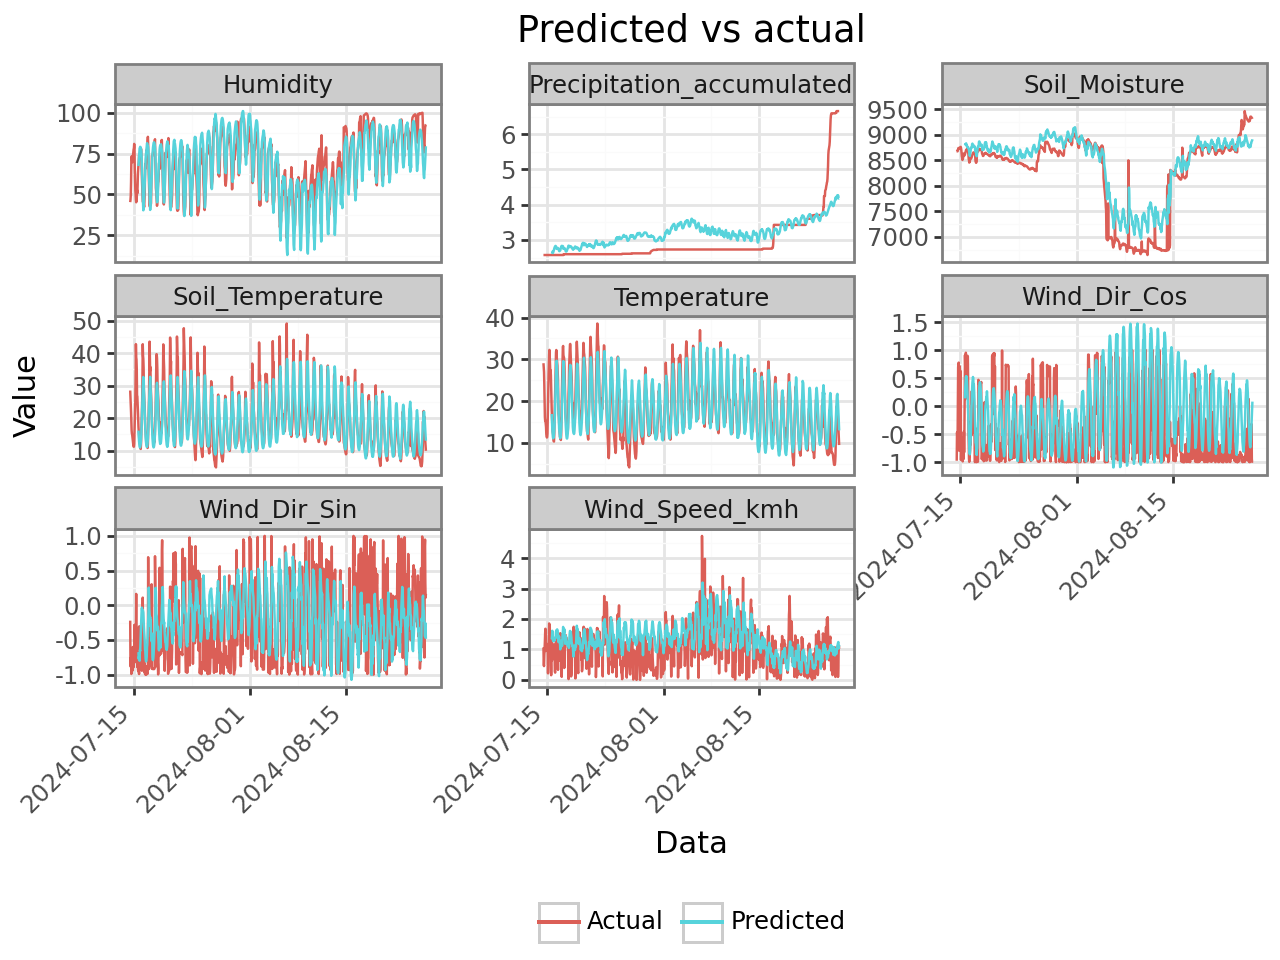

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: predict_actual.png


In [7]:
plot_columns = ['Timestamp'] + target_columns
s_melted = s_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
s_melted['type'] = 'Actual'

forecasts_t_melted = forecasts_t_df[plot_columns].melt(
    id_vars='Timestamp',
    var_name='target_column',
    value_name='value'
)
forecasts_t_melted['type'] = 'Predicted'

df_combined = pd.concat([s_melted, forecasts_t_melted])

df_combined = df_combined.rename(columns={'Timestamp': 'Date'})

plot = (
    ggplot(df_combined, aes(x='Date', y='value', color='type'))
    + geom_line()
    + facet_wrap('~ target_column', scales='free_y')
    + labs(
        title='Predicted vs actual',
        x='Data',
        y='Value',
        color='Data type'
    )
    + theme_bw()
    + theme(
        axis_text_x=element_text(rotation=45, hjust=1),
        legend_position='bottom',
        legend_title=element_blank(),
    )
)
plot.show()
plot.save('predict_actual.png', width=12, height=10, dpi=300)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

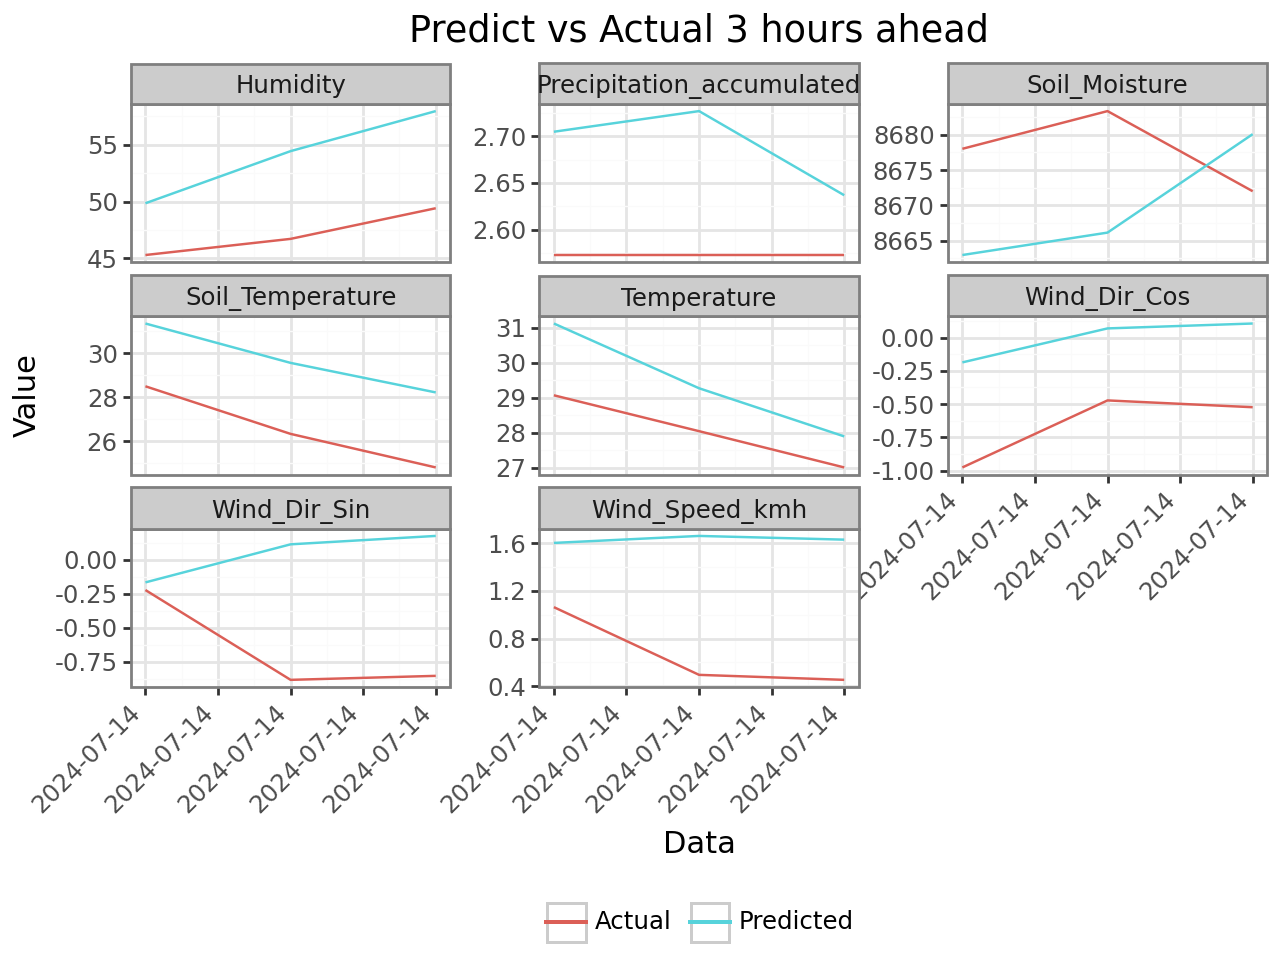

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer/predict_3.png
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(2.1703189016962923), 'RMSE': np.float64(1.473200224577872), 'MAE': np.float64(1.3894958512966202), 'R2': np.float64(-2.0574286354508584), 'SMAPE': np.float64(4.780313808586917)}, 'Precipitation_accumulated': {'MSE': np.float64(0.015182902125956951), 'RMSE': np.float64(0.12321891951302345), 'MAE': np.float64(0.11706276504271325), 'R2': np.float64(-inf), 'SMAPE': np.float64(4.438662708278004)}, 'Humidity': {'MSE': np.float64(51.141158430869716), 'RMSE': np.float64(7.151304666343737), 'MAE': np.float64(6.9412247266763645), 'R2': np.float64(-16.54532097263399), 'SMAPE': np.float64(13.585116489564967)}, 'Wind_Speed_kmh': {'MSE': np.float64(1.01713189376145), 'RMSE': np.float64(1.0085295700976993), 'MAE': np.float64(0.9632380378302458), 'R2': np.float64(-12.07120513044987), 'SMAPE': np.float64(87.37948755881997)}, 'Soil_Moisture': {'MSE': np.float64(195.37085489785548), 'RMSE': np.float64(13.977512471747449), 'MAE': np.float64(13.426015891588273), 'R2': np.

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

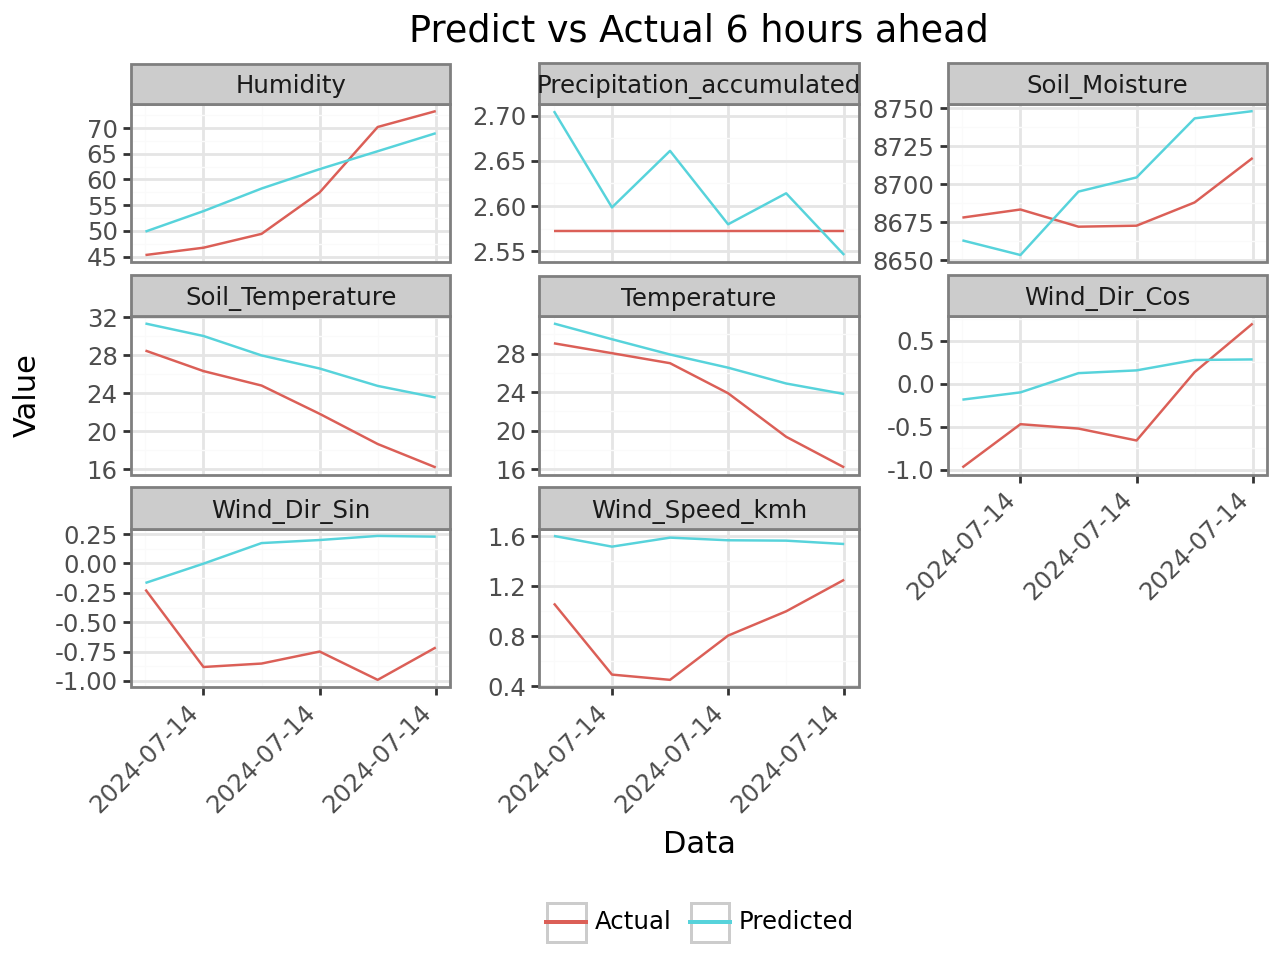

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer/predict_6.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(17.120968343257644), 'RMSE': np.float64(4.137749188055946), 'MAE': np.float64(3.3664033586075206), 'R2': np.float64(0.2303908552309072), 'SMAPE': np.float64(14.786965089789524)}, 'Precipitation_accumulated': {'MSE': np.float64(0.004754185695973641), 'RMSE': np.float64(0.06895060330391345), 'MAE': np.float64(0.05373134156607806), 'R2': np.float64(-2.4106585404389794e+28), 'SMAPE': np.float64(2.0552221403449384)}, 'Humidity': {'MSE': np.float64(35.07976134273401), 'RMSE': np.float64(5.922817010741933), 'MAE': np.float64(5.674096526554415), 'R2': np.float64(0.7155342436174268), 'SMAPE': np.float64(10.116731045745139)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.6038087854524108), 'RMSE': np.float64(0.7770513402938127), 'MAE': np.float64(0.719790796294317), 'R2': np.float64(-5.991479375051618), 'SMAPE': np.float64(63.76646390583949)}, 'Soil_Moisture': {'MSE': np.float64(1117.2449553808299), 'RMSE': np.float64(33.42521436551799), 'MAE': np.float64(31.058561771

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

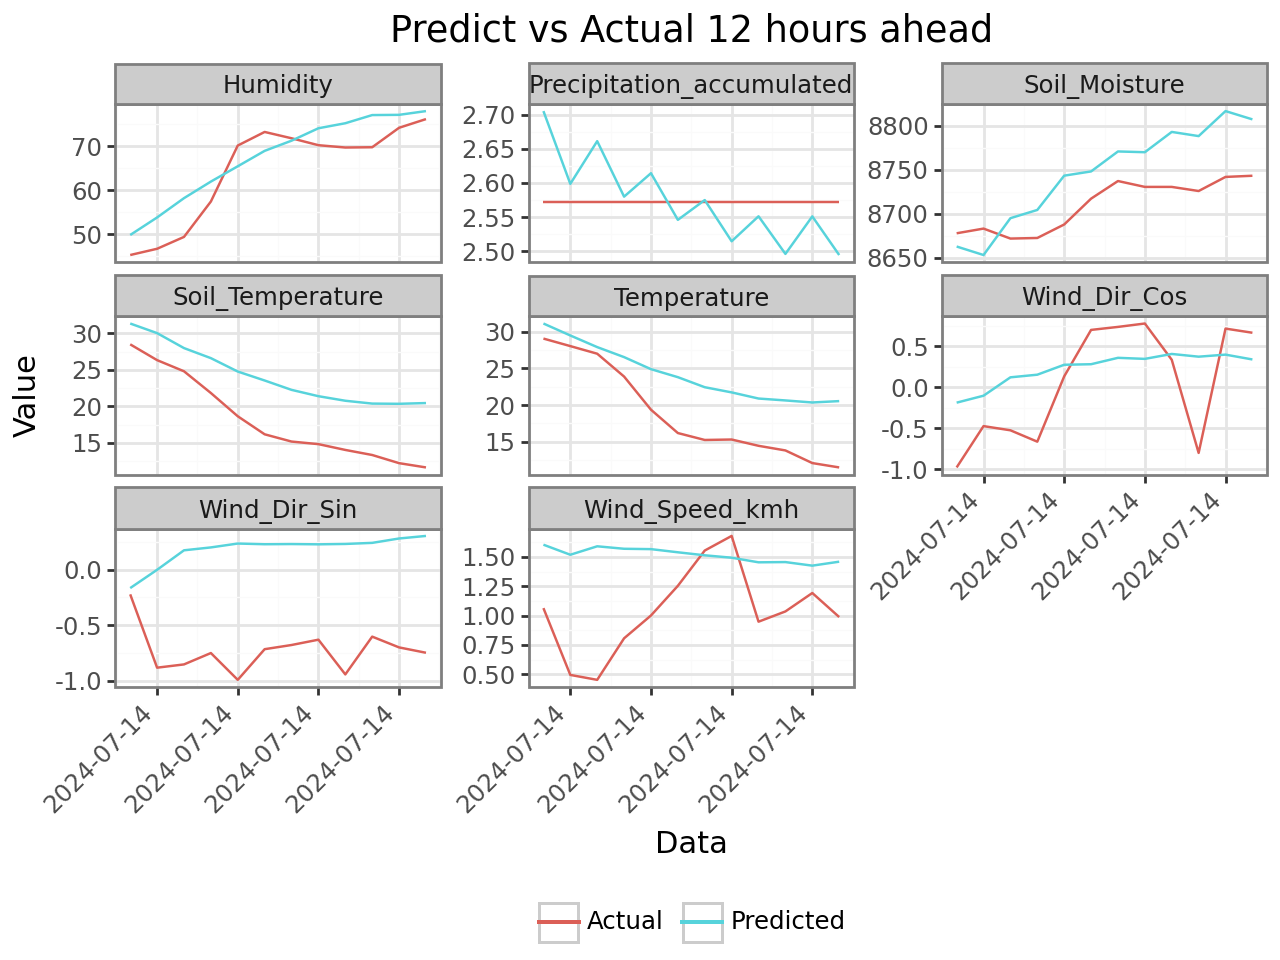

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer/predict_12.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(36.13908783182336), 'RMSE': np.float64(6.011579478957536), 'MAE': np.float64(5.364586554280089), 'R2': np.float64(0.053039718005600145), 'SMAPE': np.float64(28.746764549265816)}, 'Precipitation_accumulated': {'MSE': np.float64(0.0037291714832105804), 'RMSE': np.float64(0.06106694263847323), 'MAE': np.float64(0.04834644845721566), 'R2': np.float64(-1.8909145876183555e+28), 'SMAPE': np.float64(1.8729450560098277)}, 'Humidity': {'MSE': np.float64(26.80474128971602), 'RMSE': np.float64(5.177329551971366), 'MAE': np.float64(4.670884954504946), 'R2': np.float64(0.7776954100932552), 'SMAPE': np.float64(7.552155286757293)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.36412594692252753), 'RMSE': np.float64(0.6034284936283069), 'MAE': np.float64(0.5147781108844725), 'R2': np.float64(-2.005503002858897), 'SMAPE': np.float64(44.106151968069696)}, 'Soil_Moisture': {'MSE': np.float64(2237.9964961357136), 'RMSE': np.float64(47.30746765718615), 'MAE': np.float64(43.574465

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

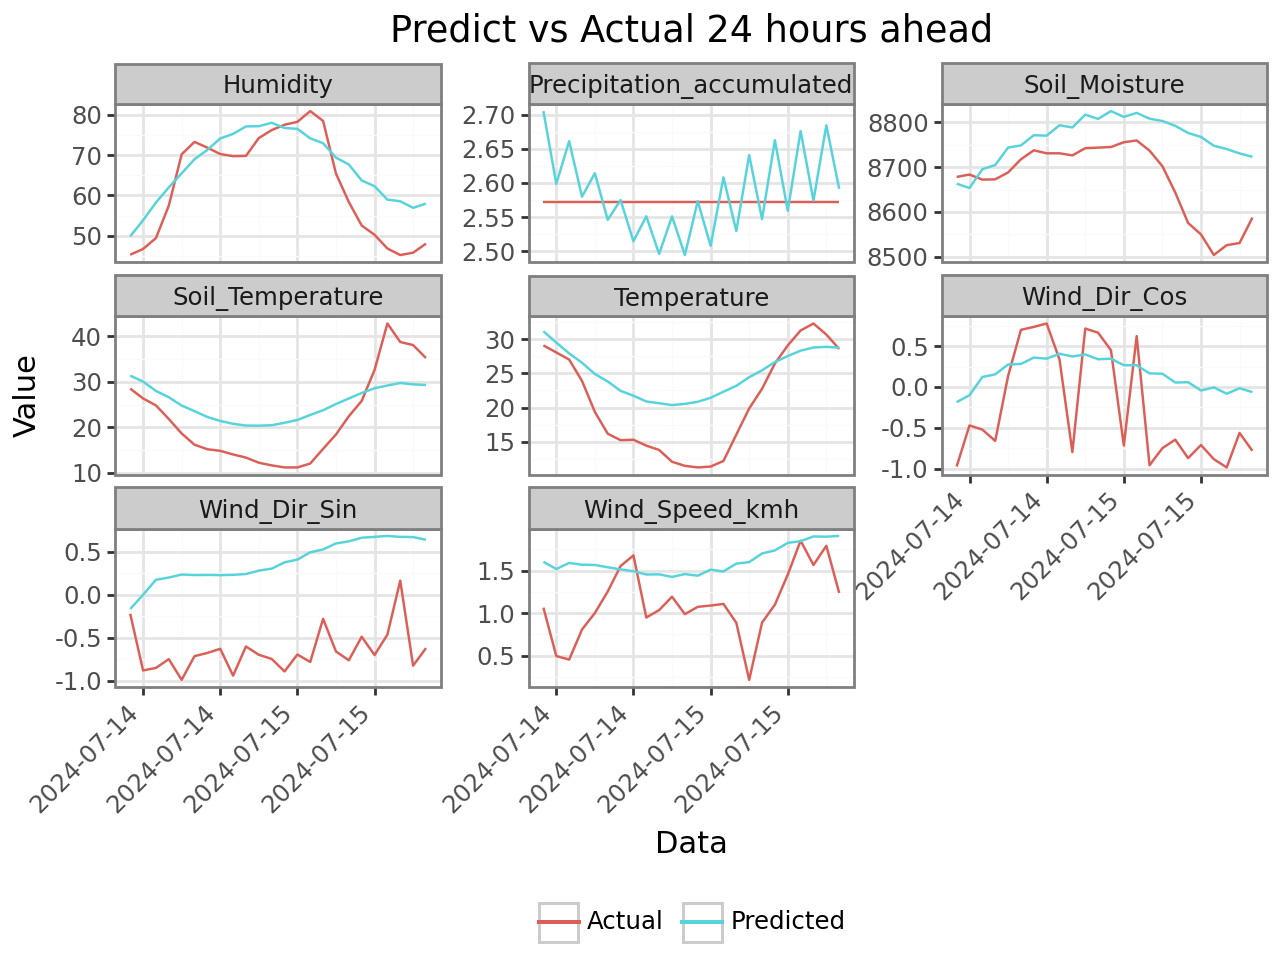

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer/predict_24.png
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/darts/metrics/metrics.py:2930: RuntimeWarning: divide by zero encountered in divide
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(34.722740616240536), 'RMSE': np.float64(5.892600496914799), 'MAE': np.float64(4.943005738003705), 'R2': np.float64(0.3499086778587147), 'SMAPE': np.float64(26.108451774367353)}, 'Precipitation_accumulated': {'MSE': np.float64(0.0037092085955212494), 'RMSE': np.float64(0.060903272453302945), 'MAE': np.float64(0.04815719664900656), 'R2': np.float64(-inf), 'SMAPE': np.float64(1.8593720803418872)}, 'Humidity': {'MSE': np.float64(55.05755872351917), 'RMSE': np.float64(7.420078080688853), 'MAE': np.float64(6.411067149098616), 'R2': np.float64(0.6589055825903389), 'SMAPE': np.float64(10.840937814865649)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.37597218024530665), 'RMSE': np.float64(0.6131657037419058), 'MAE': np.float64(0.5158638547957902), 'R2': np.float64(-1.3886286026723997), 'SMAPE': np.float64(42.86361329568746)}, 'Soil_Moisture': {'MSE': np.float64(13683.815764420297), 'RMSE': np.float64(116.9778430491018), 'MAE': np.float64(93.84105277776196), 'R2': n

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

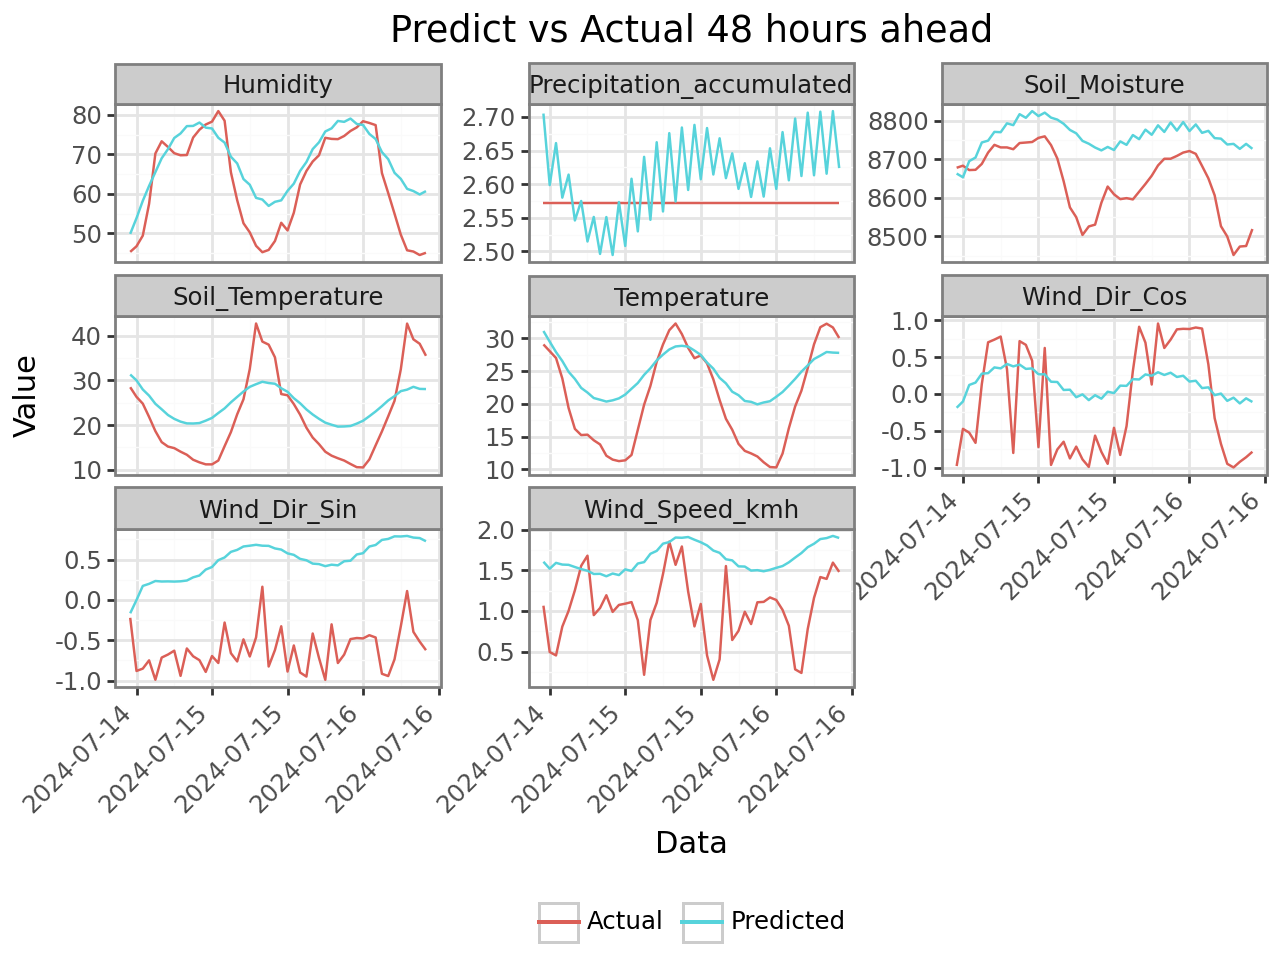

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer/predict_48.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(34.77397287280781), 'RMSE': np.float64(5.896946063243907), 'MAE': np.float64(4.9464711376972765), 'R2': np.float64(0.36775280846241865), 'SMAPE': np.float64(26.41136267809163)}, 'Precipitation_accumulated': {'MSE': np.float64(0.004961089271610708), 'RMSE': np.float64(0.07043500033087746), 'MAE': np.float64(0.05758372173430076), 'R2': np.float64(-2.5155711171772574e+28), 'SMAPE': np.float64(2.209086907087933)}, 'Humidity': {'MSE': np.float64(62.14999042342055), 'RMSE': np.float64(7.8835265220217625), 'MAE': np.float64(6.518440181404657), 'R2': np.float64(0.5926276430999188), 'SMAPE': np.float64(11.037827668353188)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.5603066417583554), 'RMSE': np.float64(0.7485363329580973), 'MAE': np.float64(0.6373472285845039), 'R2': np.float64(-2.2844316194015577), 'SMAPE': np.float64(53.592143559442455)}, 'Soil_Moisture': {'MSE': np.float64(19307.552233457154), 'RMSE': np.float64(138.95161831895717), 'MAE': np.float64(118.35035

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

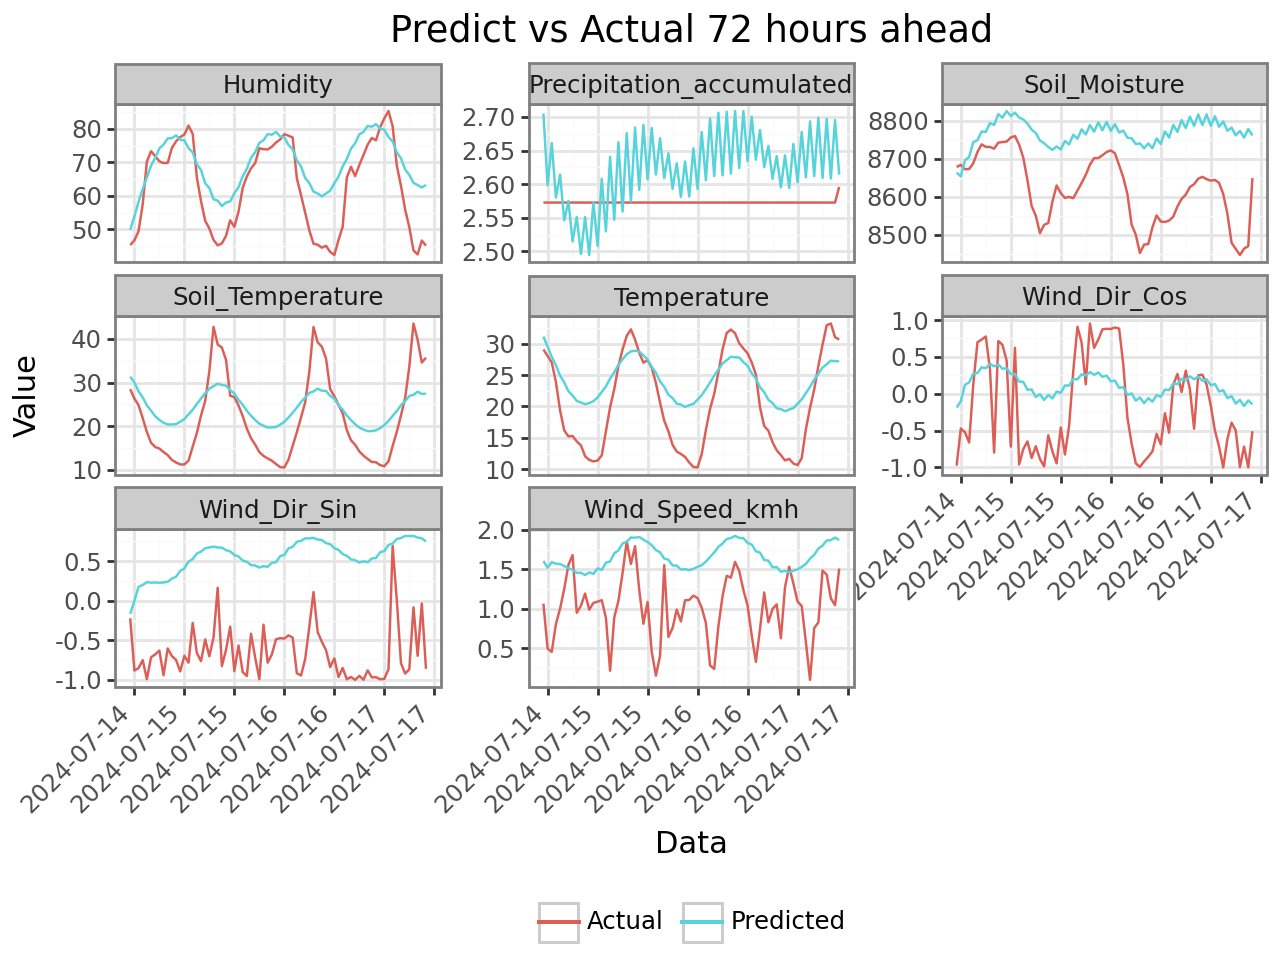

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer/predict_72.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(33.686446578246986), 'RMSE': np.float64(5.8040026342384605), 'MAE': np.float64(4.94658858842477), 'R2': np.float64(0.4130779734039488), 'SMAPE': np.float64(26.3437914745054)}, 'Precipitation_accumulated': {'MSE': np.float64(0.005565497082542774), 'RMSE': np.float64(0.07460225923216249), 'MAE': np.float64(0.06250562162111233), 'R2': np.float64(-748.5839727683589), 'SMAPE': np.float64(2.3933630949657374)}, 'Humidity': {'MSE': np.float64(94.26057318276938), 'RMSE': np.float64(9.708788450819668), 'MAE': np.float64(7.926872306919042), 'R2': np.float64(0.4524165898125535), 'SMAPE': np.float64(13.33915703932903)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.5754493542939699), 'RMSE': np.float64(0.7585837819871777), 'MAE': np.float64(0.6533209932439843), 'R2': np.float64(-2.6477764892420055), 'SMAPE': np.float64(54.503745921210566)}, 'Soil_Moisture': {'MSE': np.float64(28477.578784123398), 'RMSE': np.float64(168.7530111853516), 'MAE': np.float64(148.34323897909522

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

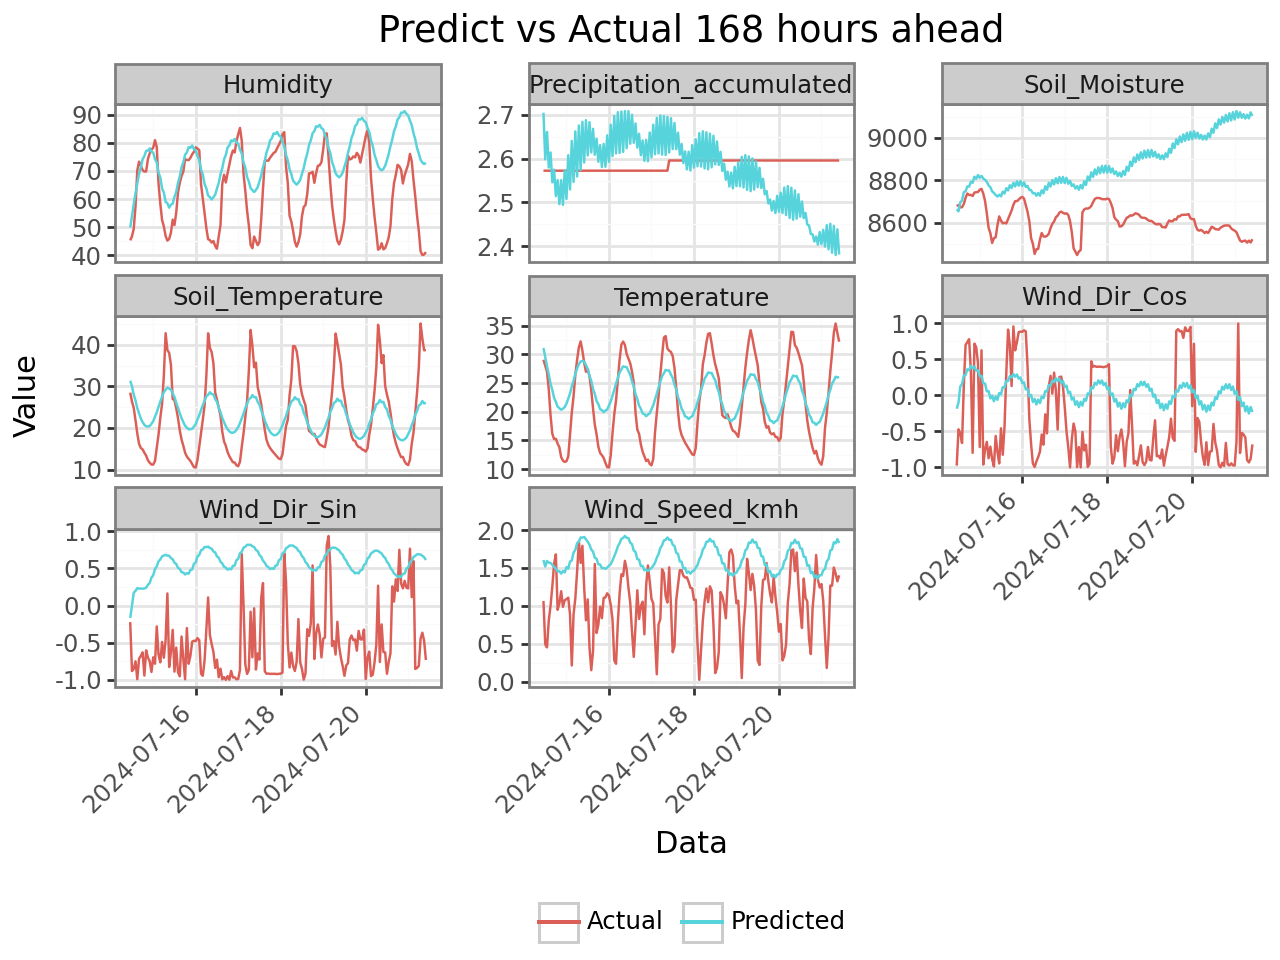

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer/predict_168.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(25.672205302783347), 'RMSE': np.float64(5.066774644957416), 'MAE': np.float64(4.299635756563771), 'R2': np.float64(0.5303565930287979), 'SMAPE': np.float64(21.403056819726604)}, 'Precipitation_accumulated': {'MSE': np.float64(0.008019943823131113), 'RMSE': np.float64(0.08955413906197253), 'MAE': np.float64(0.07199667454869334), 'R2': np.float64(-59.627476956107984), 'SMAPE': np.float64(2.805917405895701)}, 'Humidity': {'MSE': np.float64(219.4031557581849), 'RMSE': np.float64(14.812263694593913), 'MAE': np.float64(12.20925256021224), 'R2': np.float64(-0.23135106484857415), 'SMAPE': np.float64(19.220380455067147)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.5592894441034466), 'RMSE': np.float64(0.7478565665309402), 'MAE': np.float64(0.6229940935514848), 'R2': np.float64(-2.2212317253154743), 'SMAPE': np.float64(52.84099246523141)}, 'Soil_Moisture': {'MSE': np.float64(93415.71374675902), 'RMSE': np.float64(305.6398431925377), 'MAE': np.float64(262.7856046686

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

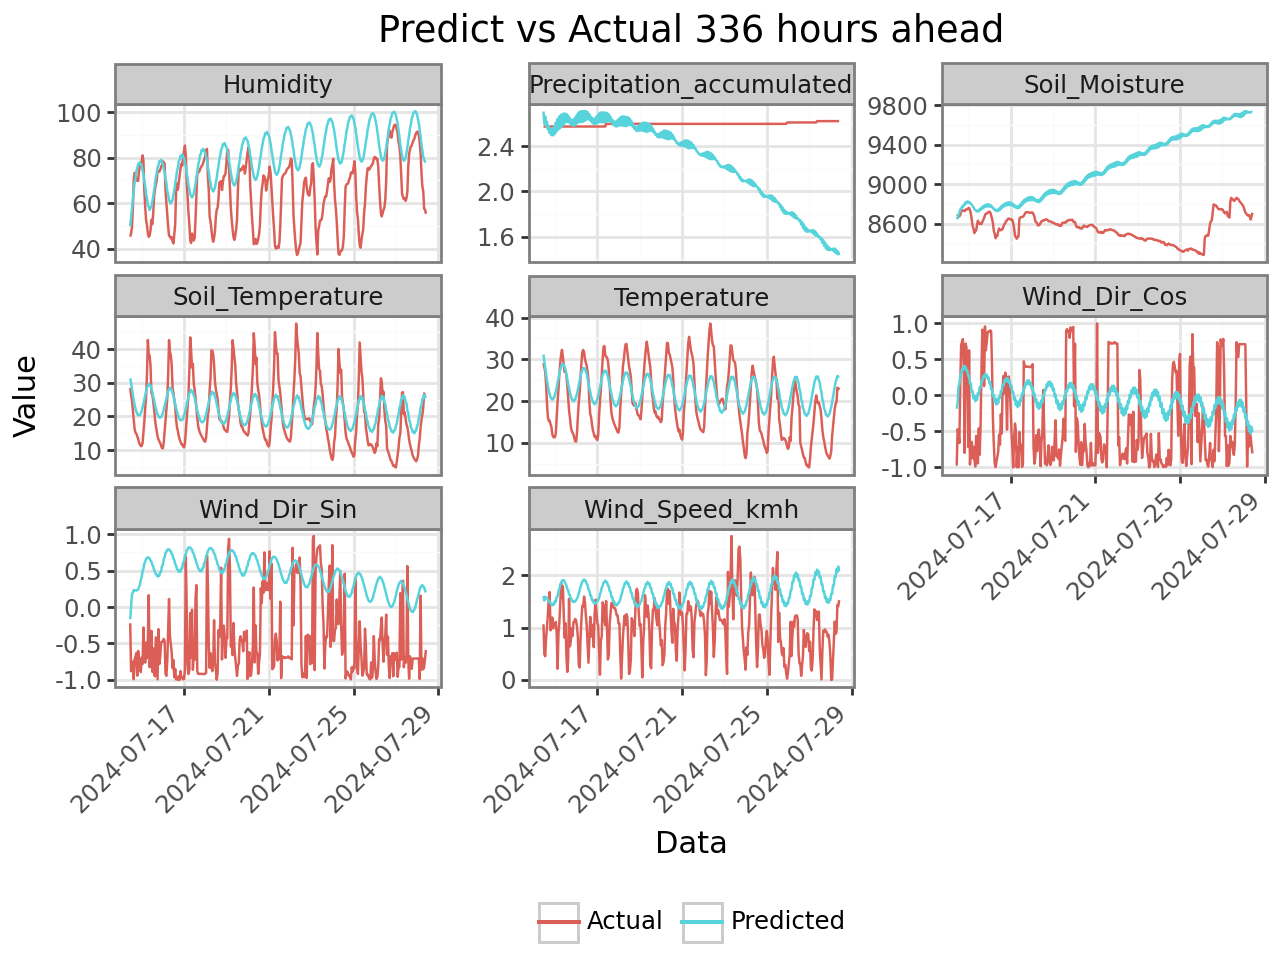

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer/predict_336.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(35.404427464526236), 'RMSE': np.float64(5.950161969604377), 'MAE': np.float64(5.033868274432358), 'R2': np.float64(0.4477268369943188), 'SMAPE': np.float64(28.386276360069317)}, 'Precipitation_accumulated': {'MSE': np.float64(0.2572691221222555), 'RMSE': np.float64(0.5072170365063219), 'MAE': np.float64(0.3610801704376228), 'R2': np.float64(-1490.023375943717), 'SMAPE': np.float64(16.119769471742522)}, 'Humidity': {'MSE': np.float64(385.275813991242), 'RMSE': np.float64(19.628444003314222), 'MAE': np.float64(16.766177329797323), 'R2': np.float64(-0.8336761725742641), 'SMAPE': np.float64(24.481145291948977)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.6522657848681551), 'RMSE': np.float64(0.8076297325310374), 'MAE': np.float64(0.6781242864707779), 'R2': np.float64(-1.5792380879744887), 'SMAPE': np.float64(58.31383976931828)}, 'Soil_Moisture': {'MSE': np.float64(510135.75262207474), 'RMSE': np.float64(714.2378823767854), 'MAE': np.float64(604.9587053003639)

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

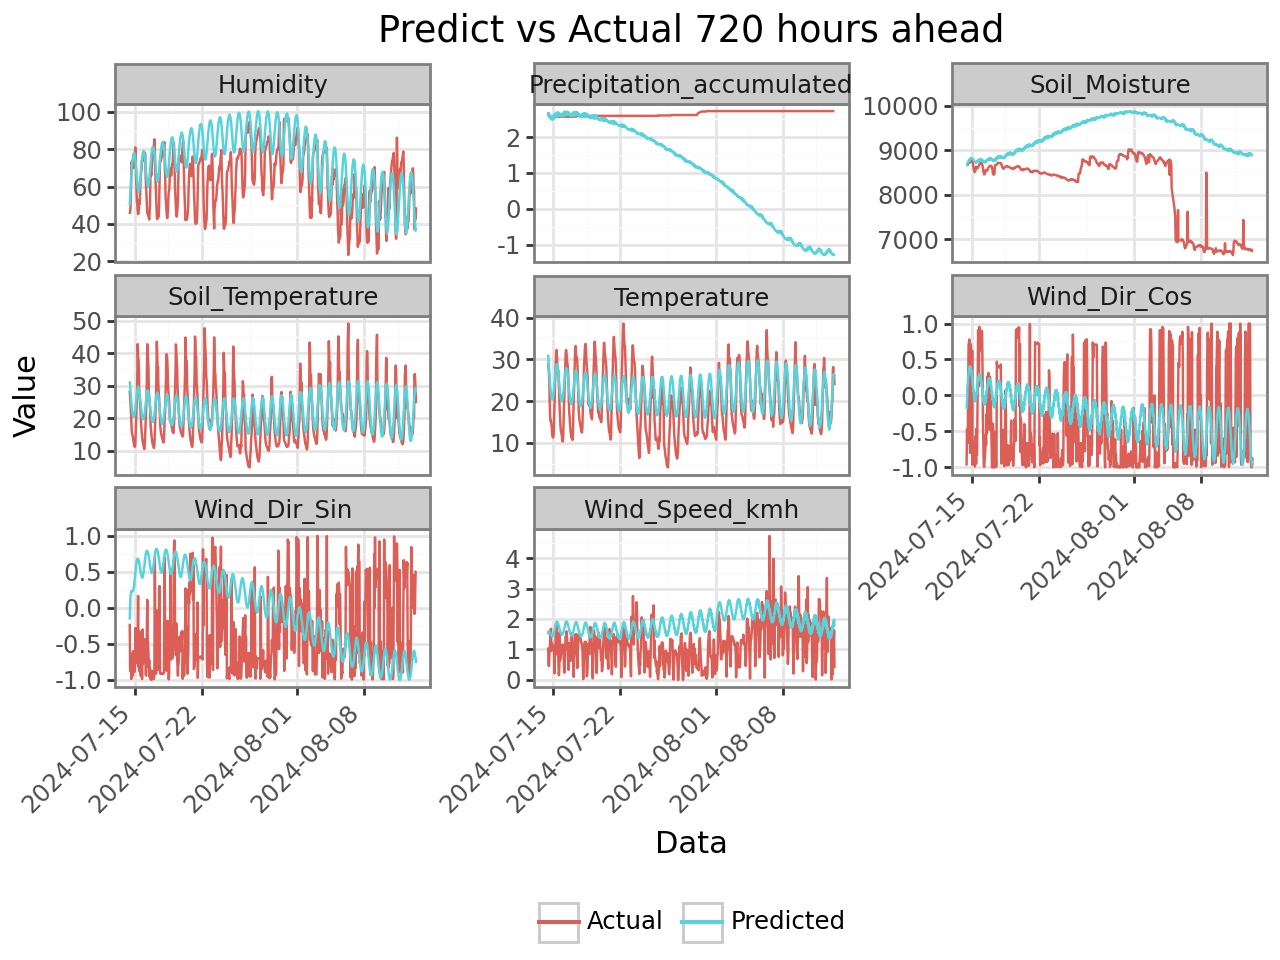

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer/predict_720.png
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'Temperature': {'MSE': np.float64(23.5272768160201), 'RMSE': np.float64(4.850492430261086), 'MAE': np.float64(3.948828615452754), 'R2': np.float64(0.5335407785889236), 'SMAPE': np.float64(21.891198674998172)}, 'Precipitation_accumulated': {'MSE': np.float64(4.745526316186453), 'RMSE': np.float64(2.17842289654384), 'MAE': np.float64(1.6616971853475162), 'R2': np.float64(-1072.5694335834967), 'SMAPE': np.float64(93.12519252290951)}, 'Humidity': {'MSE': np.float64(251.74692291487068), 'RMSE': np.float64(15.866534685143781), 'MAE': np.float64(12.934910554886933), 'R2': np.float64(0.060179492983111094), 'SMAPE': np.float64(20.106875350316983)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.8992464768614639), 'RMSE': np.float64(0.9482860733246397), 'MAE': np.float64(0.7888588093543755), 'R2': np.float64(-1.0178651545088178), 'SMAPE': np.float64(60.26509866933072)}, 'Soil_Moisture': {'MSE': np.float64(2038979.9684245107), 'RMSE': np.float64(1427.9285585856564), 'MAE': np.float64(1189.9491633185605)

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

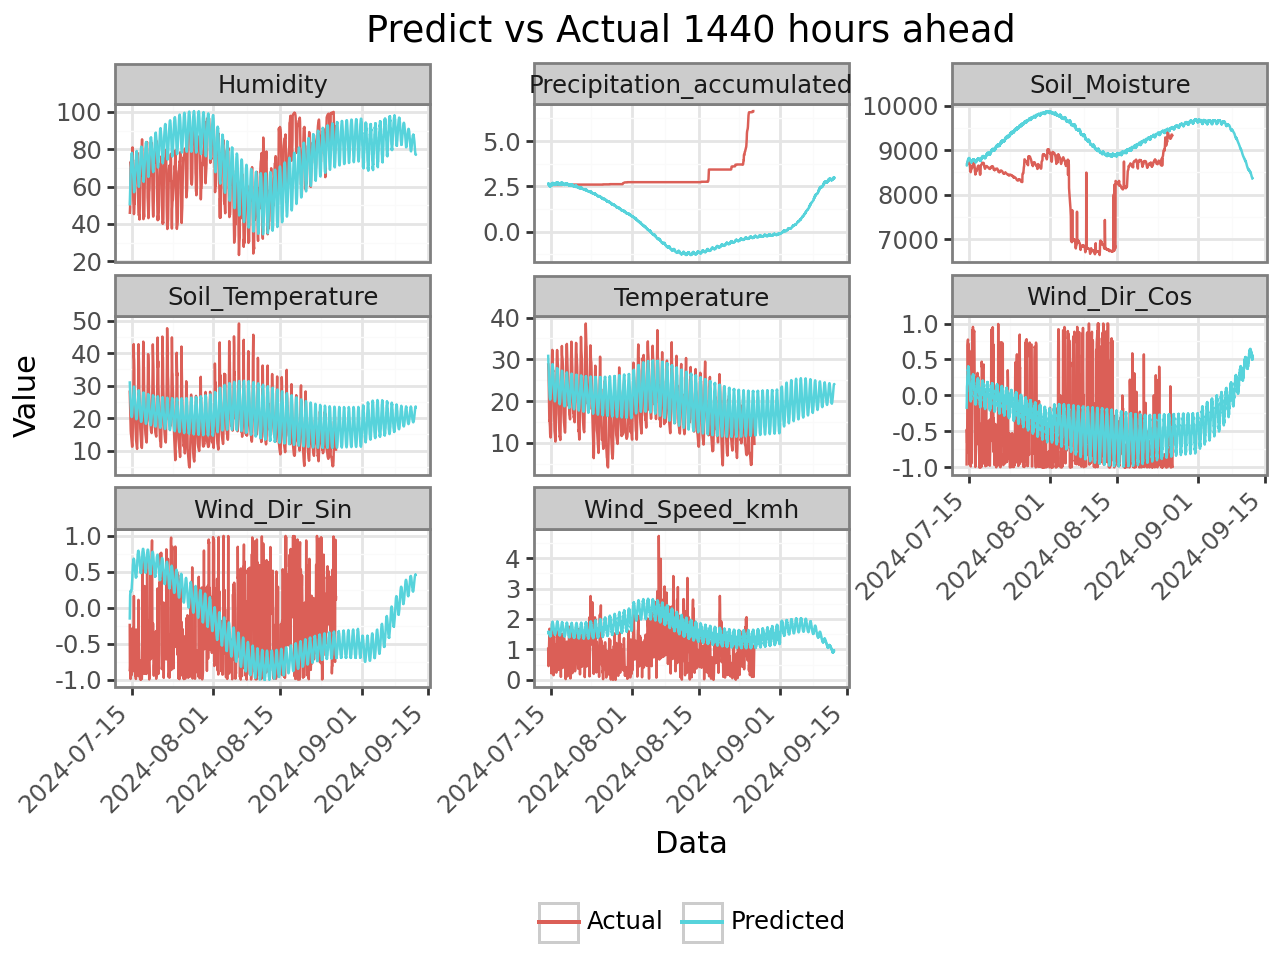

/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 10 in image.
/home/eduardo/Documentos/Water-Cycle-Neural-Network/venv/lib/python3.12/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: results/Transformer/predict_1440.png


{'Temperature': {'MSE': np.float64(21.26646021600771), 'RMSE': np.float64(4.611557244142992), 'MAE': np.float64(3.740815488492937), 'R2': np.float64(0.5772069389407459), 'SMAPE': np.float64(22.584068123377552)}, 'Precipitation_accumulated': {'MSE': np.float64(9.671867843159838), 'RMSE': np.float64(3.1099626755251966), 'MAE': np.float64(2.5231625551510093), 'R2': np.float64(-14.662302295560453), 'SMAPE': np.float64(125.86718556502395)}, 'Humidity': {'MSE': np.float64(243.2570254568154), 'RMSE': np.float64(15.59669918466133), 'MAE': np.float64(12.671730940629057), 'R2': np.float64(0.21711335379269003), 'SMAPE': np.float64(18.992464717126705)}, 'Wind_Speed_kmh': {'MSE': np.float64(0.794903686647973), 'RMSE': np.float64(0.8915737135245593), 'MAE': np.float64(0.7411539138237822), 'R2': np.float64(-0.9094942841840403), 'SMAPE': np.float64(61.78381973796461)}, 'Soil_Moisture': {'MSE': np.float64(1603523.9854986602), 'RMSE': np.float64(1266.303275482876), 'MAE': np.float64(1018.7225818694556),

In [8]:
m = "Transformer"
for i in [3,6,12,24,48,72,168,336,720,1440]:
    pred = model.predict(
        series=best_train_scaled,
        n=i,
        verbose=True
    )

    metrics={}

    pred_t = best_scaler.inverse_transform(pred)
    pred_df = pred_t.to_dataframe()
    pred_df = pred_df.reset_index()
    pred_df = pred_df.rename(columns={"time": "Timestamp"})
    plot_columns = ['Timestamp'] + target_columns
    pred_melted = pred_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    pred_melted['type'] = 'Predicted'

    # Get validation data for comparison
    val_t = best_scaler.inverse_transform(best_val_scaled[:i])
    val_df = val_t.to_dataframe()
    val_df = val_df.reset_index()
    val_df = val_df.rename(columns={"time": "Timestamp"})
    val_melted = val_df[plot_columns].melt(
        id_vars='Timestamp',
        var_name='target_column',
        value_name='value'
    )
    val_melted['type'] = 'Actual'

    # Combine predicted and validation data
    combined_df = pd.concat([pred_melted, val_melted])

    plot = (
        ggplot(combined_df, aes(x='Timestamp', y='value', color='type'))
        + geom_line()
        + facet_wrap('~ target_column', scales='free_y')
        + labs(
            title=f'Predict vs Actual {i} hours ahead',
            x='Data',
            y='Value',
            color='Data type'
        )
        + theme_bw()
        + theme(
            axis_text_x=element_text(rotation=45, hjust=1),
            legend_position='bottom',
            legend_title=element_blank(),

        )
    )
    plot.show()
    plot.save(f'results/{m}/predict_{i}.png', width=12, height=10, dpi=300)


    s = best_scaler.inverse_transform(best_val_scaled[:i])
    for target in target_columns:
        metrics[target] = {
            'MSE': mse(s[target], pred_t[target]),
            'RMSE': rmse(s[target], pred_t[target]),
            'MAE': mae(s[target], pred_t[target]),
            'R2': r2_score(s[target], pred_t[target]),
            'SMAPE': smape(s[target], pred_t[target]),
        }
    print(metrics)
    with open(f'results/{m}/metrics{i}.json', 'w') as f:
        json.dump(metrics, f, indent=4)


In [9]:
with open('best_metrics.json', 'w') as f:
    json.dump(best_metrics.to_dict(), f, indent=4)